# Import

In [1]:
# this library is used for drawing the charts easily.
# use this library to draw your charts in this homework.
!pip install -q git+https://github.com/MJAHMADEE/docs

  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Input
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from keras import backend as K
from keras.layers import Dense, Dropout
from keras.models import Model, load_model
import glob
from random import sample
import math

# 1.Prepare data

In [3]:
# unzip data and load them
!gdown 1i7IPJGE-TCxp8cPUvWu_yZh0K4X9HTrs
!unzip time-series.zip -d time-series

Downloading...
From: https://drive.google.com/uc?id=1i7IPJGE-TCxp8cPUvWu_yZh0K4X9HTrs
To: /content/time-series.zip
100% 7.45M/7.45M [00:00<00:00, 39.6MB/s]
Archive:  time-series.zip
  inflating: time-series/4.csv       
  inflating: time-series/5.csv       
  inflating: time-series/6.csv       
  inflating: time-series/7.csv       
  inflating: time-series/8.csv       
  inflating: time-series/9.csv       
  inflating: time-series/10.csv      
  inflating: time-series/11.csv      
  inflating: time-series/12.csv      
  inflating: time-series/13.csv      
  inflating: time-series/14.csv      
  inflating: time-series/15.csv      
  inflating: time-series/16.csv      
  inflating: time-series/17.csv      
  inflating: time-series/18.csv      
  inflating: time-series/19.csv      
  inflating: time-series/20.csv      
  inflating: time-series/21.csv      
  inflating: time-series/22.csv      
  inflating: time-series/23.csv      
  inflating: time-series/24.csv      
  inflating: time-se

In [4]:
# show chart of 5 dataset(csv file) randomly

def load_data(path):
  df_list = []
  dataset = sorted(glob.glob(f'{path}/*.csv'))
  for data in dataset:
    d = pd.read_csv(data)
    d.index = d['timestamp']
    d = d[['value', 'label']]
    df_list.append(d)
    print(d)
  return df_list

def show_chart(df_list, num):
  index = sample(range(len(df_list)), num)
  for i in index:
      df_list[i].plot()

In [5]:
df_list = load_data('time-series')

               value  label
timestamp                  
1493568000  1.901639      0
1493568060  1.786885      0
1493568120  2.000000      0
1493568180  1.885246      0
1493568240  1.819672      0
...              ...    ...
1501475400  2.684211      0
1501475460  2.526316      0
1501475520  2.614035      0
1501475580  2.736842      0
1501475640  2.491228      0

[128562 rows x 2 columns]
            value  label
timestamp               
1493568000   2.25      0
1493568060   3.15      0
1493568120   3.05      0
1493568180   3.00      0
1493568240   2.30      0
...           ...    ...
1501475400   5.70      0
1501475460   4.55      0
1501475520   5.45      0
1501475580   6.80      0
1501475640   5.70      0

[129128 rows x 2 columns]
                   value  label
timestamp                      
1.416722e+09   50.565276      0
1.416726e+09  115.885387      0
1.416730e+09  231.703659      0
1.416733e+09  313.084513      0
1.416737e+09  320.553707      0
...                  ...    ...
1

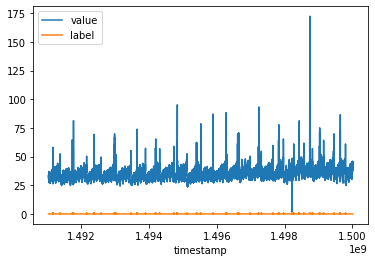

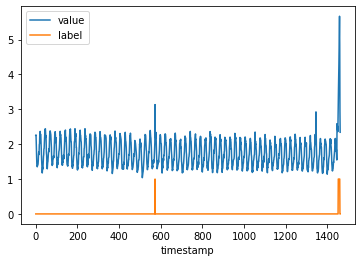

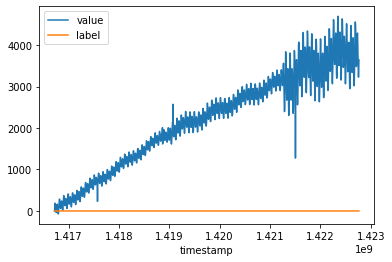

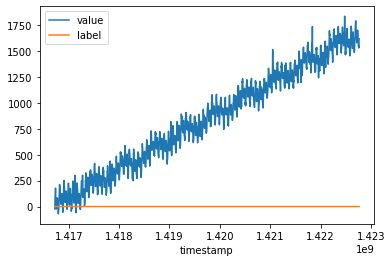

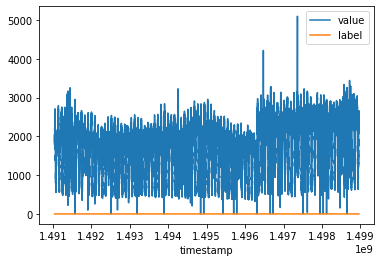

In [ ]:
show_chart(df_list, 5)

In [6]:
TIME_STEP = 32

In [7]:
def create_dataset(data_x, data_y, timestep):
  n = data_x.shape[0]
  x = np.zeros((n-timestep, timestep, 1))
  y = np.zeros((n-timestep,))
  for i in range(timestep, n):
      temp = 0
      for j in range(i-timestep, i):
          x[i-timestep, temp, 0] = data_x[j, 0]
          temp += 1
      y[i-timestep] = data_y[i, 0]
  return x, y

In [8]:
x, y = [], []
for df in df_list:
  x.append(df['value'].values.reshape(-1, 1))
  y.append(df['label'].values.reshape(-1, 1))
x, y = np.array(x, dtype=object), np.array(y, dtype=object)

In [9]:
for i in range(x.shape[0]):
  x[i], y[i] = create_dataset(x[i], y[i], TIME_STEP)

In [10]:
x.shape

(81,)

In [11]:
x[0].shape

(128530, 32, 1)

In [12]:
y[0].shape

(128530,)

In [13]:
x_concate, y_concate = np.concatenate(x), np.concatenate(y)

In [14]:
x_concate.shape

(1510889, 32, 1)

In [15]:
y_concate.shape

(1510889,)

In [16]:
# split data to train and test
x_train, x_test, y_train, y_test = train_test_split(x_concate, y_concate, test_size=0.2, random_state=0)

In [17]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1208711, 32, 1)
y_train shape: (1208711,)
x_test shape: (302178, 32, 1)
y_test shape: (302178,)


In [18]:
x_train[0].shape

(32, 1)

# Metric functions

In [19]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 3. Create and train 3 RNN model(Simple, LSTM, GRU)

In [20]:
HIDDEN_UNITS = 32
BATCH_SIZE = 64
EPOCHS = 10

In [21]:
def build_model(rnn_layer):
  inputs = Input(shape=(TIME_STEP, 1))
  x = rnn_layer(HIDDEN_UNITS, return_sequences=False)(inputs)
  # x = Dropout(rate=0.2)(x)
  x = Dense(units=HIDDEN_UNITS / 2, activation='relu')(x)
  outputs = Dense(units=1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=outputs)
  model.summary()
  return model

In [23]:
def compile_fit(model, x_train, y_train, x_test, y_test, epochs=EPOCHS):
  model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=(f1_score_m, recall_m, precision_m)
  )

  return model.fit(
      x_train, y_train,
      epochs=epochs,
      batch_size=BATCH_SIZE,
      validation_data=(x_test, y_test),
      callbacks=keras.callbacks.EarlyStopping(monitor='val_f1_score_m',
                                              patience=5,
                                              mode='max',
                                              restore_best_weights=True)
  )

In [ ]:
# Simple
simple = build_model(layers.SimpleRNN)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_fit(simple, x_train, y_train, x_test, y_test) 

Epoch 1/10
18887/18887 [==============================] - 409s 22ms/step - loss: 0.0683 - f1_score_m: 0.1383 - recall_m: 0.1238 - precision_m: 0.1799 - val_loss: 0.0584 - val_f1_score_m: 0.2238 - val_recall_m: 0.2056 - val_precision_m: 0.2792
Epoch 2/10
18887/18887 [==============================] - 403s 21ms/step - loss: 0.0575 - f1_score_m: 0.1960 - recall_m: 0.1784 - precision_m: 0.2466 - val_loss: 0.0531 - val_f1_score_m: 0.2611 - val_recall_m: 0.2393 - val_precision_m: 0.3214
Epoch 3/10
18887/18887 [==============================] - 405s 21ms/step - loss: 0.0588 - f1_score_m: 0.1780 - recall_m: 0.1619 - precision_m: 0.2244 - val_loss: 0.0576 - val_f1_score_m: 0.2542 - val_recall_m: 0.2386 - val_precision_m: 0.3075
Epoch 4/10
18887/18887 [==============================] - 408s 22ms/step - loss: 0.0561 - f1_score_m: 0.2181 - recall_m: 0.2006 - precision_m: 0.2704 - val_loss: 0.0539 - val_f1_score_m: 0.2261 - val_recall_m: 0.2049 - val_precision_m: 0.2834
Epoch 5/10
18887/18887 [====

In [ ]:
# LSTM
lstm = build_model(layers.LSTM)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_fit(lstm, x_train, y_train, x_test, y_test) 

Epoch 1/10
18887/18887 [==============================] - 129s 7ms/step - loss: 0.0596 - f1_score_m: 0.2257 - recall_m: 0.2079 - precision_m: 0.2759 - val_loss: 0.0486 - val_f1_score_m: 0.3514 - val_recall_m: 0.3327 - val_precision_m: 0.4099
Epoch 2/10
18887/18887 [==============================] - 117s 6ms/step - loss: 0.0453 - f1_score_m: 0.3792 - recall_m: 0.3612 - precision_m: 0.4353 - val_loss: 0.0475 - val_f1_score_m: 0.3991 - val_recall_m: 0.3882 - val_precision_m: 0.4500
Epoch 3/10
18887/18887 [==============================] - 117s 6ms/step - loss: 0.0415 - f1_score_m: 0.4187 - recall_m: 0.4002 - precision_m: 0.4738 - val_loss: 0.0450 - val_f1_score_m: 0.3855 - val_recall_m: 0.3787 - val_precision_m: 0.4325
Epoch 4/10
18887/18887 [==============================] - 126s 7ms/step - loss: 0.0406 - f1_score_m: 0.4265 - recall_m: 0.4100 - precision_m: 0.4799 - val_loss: 0.0411 - val_f1_score_m: 0.4263 - val_recall_m: 0.4084 - val_precision_m: 0.4814
Epoch 5/10
18887/18887 [========

In [ ]:
# GRU
gru = build_model(layers.GRU)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,905
Trainable params: 3,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_fit(gru, x_train, y_train, x_test, y_test) 

Epoch 1/10
18887/18887 [==============================] - 114s 6ms/step - loss: 0.0653 - f1_score_m: 0.1736 - recall_m: 0.1581 - precision_m: 0.2169 - val_loss: 0.0522 - val_f1_score_m: 0.3735 - val_recall_m: 0.3614 - val_precision_m: 0.4259
Epoch 2/10
18887/18887 [==============================] - 113s 6ms/step - loss: 0.0473 - f1_score_m: 0.3736 - recall_m: 0.3531 - precision_m: 0.4334 - val_loss: 0.0442 - val_f1_score_m: 0.4097 - val_recall_m: 0.3991 - val_precision_m: 0.4599
Epoch 3/10
18887/18887 [==============================] - 113s 6ms/step - loss: 0.0392 - f1_score_m: 0.4385 - recall_m: 0.4237 - precision_m: 0.4877 - val_loss: 0.0364 - val_f1_score_m: 0.4527 - val_recall_m: 0.4382 - val_precision_m: 0.5015
Epoch 4/10
18887/18887 [==============================] - 122s 6ms/step - loss: 0.0355 - f1_score_m: 0.4660 - recall_m: 0.4550 - precision_m: 0.5108 - val_loss: 0.0359 - val_f1_score_m: 0.4861 - val_recall_m: 0.4808 - val_precision_m: 0.5232
Epoch 5/10
18887/18887 [========

# 4. Preprocces data to get better performance

In [24]:
x_preprocess, y_preprocess = [], []
for df in df_list:
  x_preprocess.append(df['value'].values.reshape(-1, 1))
  y_preprocess.append(df['label'].values.reshape(-1, 1))
x_preprocess, y_preprocess = np.array(x_preprocess, dtype=object), np.array(y_preprocess, dtype=object)

In [25]:
# Preprocces method 1
# MinMaxScaler

min_max_scaler = MinMaxScaler()
for i in range(x_preprocess.shape[0]):
  x_preprocess[i] = min_max_scaler.fit_transform(x_preprocess[i])

In [26]:
# Preprocces method 2
# Normalization using L2 norm

norm_l2 = list(math.sqrt(sum(list((i**2) for i in x_preprocess[r]))) for r in range(len(x_preprocess)))
x_preprocess = x_preprocess / norm_l2

In [27]:
for i in range(x_preprocess.shape[0]):
  x_preprocess[i], y_preprocess[i] = create_dataset(x_preprocess[i], y_preprocess[i], TIME_STEP)

In [28]:
x_preprocess_concate, y_preprocess_concate = np.concatenate(x_preprocess), np.concatenate(y_preprocess)

In [29]:
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_preprocess_concate, y_preprocess_concate, test_size=0.2, random_state=0)

In [ ]:
# Train 3 models again
simple_new = build_model(layers.SimpleRNN)
history = compile_fit(simple_new, x_train_new, y_train_new, x_test_new, y_test_new) 

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
18887/18887 [==============================] - 409s 22ms/step - loss: 0.0723 - f1_score_m: 0.1203 - recall_m: 0.1074 - precision_m: 0.1558 - val_loss: 0.0573 - val_f1_score_m: 0.

In [ ]:
lstm_new = build_model(layers.LSTM)
history = compile_fit(lstm_new, x_train_new, y_train_new, x_test_new, y_test_new) 

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
18887/18887 [==============================] - 117s 6ms/step - loss: 0.0589 - f1_score_m: 0.2224 - recall_m: 0.2047 - precision_m: 0.2722 - val_loss: 0.0502 - val_f1_score_m: 0.3

In [ ]:
gru_new = build_model(layers.GRU)
history = compile_fit(gru_new, x_train_new, y_train_new, x_test_new, y_test_new) 

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 gru_1 (GRU)                 (None, 32)                3360      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,905
Trainable params: 3,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
18887/18887 [==============================] - 111s 6ms/step - loss: 0.0592 - f1_score_m: 0.2465 - recall_m: 0.2304 - precision_m: 0.2937 - val_loss: 0.0438 - val_f1_score_m: 0.4

# 6. Train a self supervise model

In [ ]:
def fit_self_supervised_model(x_train, y_train, x_test, y_test):
  inputs = Input(shape=(TIME_STEP, 1))
  x = layers.LSTM(HIDDEN_UNITS, return_sequences=True)(inputs)
  x = Dropout(rate=0.2)(x)
  x = layers.LSTM(units=int(HIDDEN_UNITS / 2), return_sequences=False)(x)
  outputs = Dense(units=1)(x)
  model = Model(inputs=inputs, outputs=outputs)
  model.summary()

  model.compile(
    optimizer='adam',
    loss='mse',
    metrics=(f1_score_m, recall_m, precision_m)
  )

  history = model.fit(
      x_train, y_train,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      validation_data=(x_test, y_test),
      callbacks=keras.callbacks.EarlyStopping(monitor='val_f1_score_m',
                                              patience=3,
                                              mode='max',
                                              restore_best_weights=True)
  )
  model.save('self_supervised.h5')
  return history

In [ ]:
data = []
for df in df_list:
  data.append(df['value'].values.reshape(-1, 1))
data = np.array(data, dtype=object)

x_new, y_new = [], []
for df in df_list:
  data_new, label_new = [], []
  data = df['value'].values.reshape(-1, 1)
  for i in range(data.shape[0] - TIME_STEP):
    data_new.append([data[i + j] for j in range(TIME_STEP)])
    label_new.append(data[i + TIME_STEP])
  x_new.append(np.array(data_new))
  y_new.append(np.array(label_new))
x_new, y_new = np.array(x_new, dtype='object'), np.array(y_new, dtype='object')

In [ ]:
for i in range(x_new.shape[0]):
  x_new[i], y_new[i] = create_dataset(x_new[i], y_new[i], TIME_STEP)

In [ ]:
x_concate_new, y_concate_new = np.concatenate(x_new), np.concatenate(y_new)
x_train_supervised, x_test_supervised, y_train_supervised, y_test_supervised = train_test_split(x_concate_new, y_concate_new, test_size=0.2, random_state=0)

In [ ]:
# compile and train the model
self_supervised_history = fit_self_supervised_model(x_train_supervised, y_train_supervised, x_test_supervised, y_test_supervised)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 32, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
18854/18854 [==============================] - 1

In [ ]:
# delete last layer of model
self_supervised_model = load_model("self_supervised.h5", custom_objects={"f1_score_m": f1_score_m, "recall_m": recall_m, "precision_m": precision_m})
lstm_layer = self_supervised_model.layers[-2]
my_model = Model(inputs=self_supervised_model.input, outputs=lstm_layer.output)

In [ ]:
# freeze all remaining layers except the last one
for layer in my_model.layers[:-1]:
    layer.trainable = False

In [ ]:
# add 2 dence layer to the model
d = layers.Dense(HIDDEN_UNITS / 4)(my_model.output)
d = layers.Dense(1, activation='sigmoid')(d)
new_model = keras.Model(inputs=my_model.input, outputs=d)
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 32, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7,633
Trainable params: 3,281
Non-trainable p

In [ ]:
# train the main task(anomaly detection)
history = compile_fit(new_model, x_train, y_train, x_test, y_test) 

Epoch 1/10
18887/18887 [==============================] - 145s 8ms/step - loss: 0.0772 - f1_score_m: 0.0855 - recall_m: 0.0743 - precision_m: 0.1167 - val_loss: 0.0717 - val_f1_score_m: 0.1203 - val_recall_m: 0.1032 - val_precision_m: 0.1621
Epoch 2/10
18887/18887 [==============================] - 141s 7ms/step - loss: 0.0697 - f1_score_m: 0.1257 - recall_m: 0.1086 - precision_m: 0.1693 - val_loss: 0.0667 - val_f1_score_m: 0.1369 - val_recall_m: 0.1188 - val_precision_m: 0.1816
Epoch 3/10
18887/18887 [==============================] - 138s 7ms/step - loss: 0.0640 - f1_score_m: 0.1343 - recall_m: 0.1168 - precision_m: 0.1793 - val_loss: 0.0606 - val_f1_score_m: 0.1468 - val_recall_m: 0.1284 - val_precision_m: 0.1924
Epoch 4/10
18887/18887 [==============================] - 141s 7ms/step - loss: 0.0615 - f1_score_m: 0.1436 - recall_m: 0.1253 - precision_m: 0.1904 - val_loss: 0.0595 - val_f1_score_m: 0.1528 - val_recall_m: 0.1334 - val_precision_m: 0.2005
Epoch 5/10
18887/18887 [========

# 7. Handle unbalanced data problem

0    1484686
1      28795
Name: label, dtype: int64


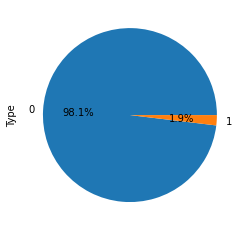

In [ ]:
all_data = pd.concat(df_list, ignore_index=True)
print(all_data["label"].value_counts())

all_data.groupby('label').size().plot(kind='pie',
                                       y = "label",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [ ]:
zeros = all_data[(all_data['label'] == 0)] 
ones = all_data[(all_data['label'] == 1)]
print(zeros.shape)
print(ones.shape)

(1484686, 2)
(28795, 2)


In [ ]:
from sklearn.utils import resample

for df in df_list:
  df_zeros = df[(df['label'] == 0)] 
  df_ones = df[(df['label'] == 1)]
  df_zero_downsample = resample(zeros,
              replace=True,
              n_samples=len(ones),
              random_state=42)

x_downsampled, y_downsampled = [], []
df_list_downsampled = df_list.copy()
for i, df in enumerate(df_list):
  df_zeros = df[(df['label'] == 0)] 
  df_ones = df[(df['label'] == 1)]
  df_zero_downsample = resample(zeros,
              replace=True,
              n_samples=len(ones),
              random_state=42)
  df_downsampled = pd.concat([df_zero_downsample, ones])
  df_list_downsampled[i] = df_downsampled

  x_downsampled.append(df_downsampled['value'].values.reshape(-1, 1))
  y_downsampled.append(df_downsampled['label'].values.reshape(-1, 1))
  
x_downsampled, y_downsampled = np.array(x_downsampled, dtype=object), np.array(y_downsampled, dtype=object)

0    2332395
1    2332395
Name: label, dtype: int64


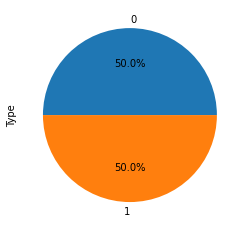

In [ ]:
data_downsampled = pd.concat(df_list_downsampled, ignore_index=True)
print(data_downsampled["label"].value_counts())

data_downsampled.groupby('label').size().plot(kind='pie',
                                       y = "label",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [ ]:
x_downsampled_new, y_downsampled_new = [], []
for i in range(x_downsampled.shape[0]):
  data = create_dataset(x_downsampled[i], y_downsampled[i], TIME_STEP)
  x_downsampled_new.append(data[0])
  y_downsampled_new.append(data[1])

In [ ]:
np.array(x_downsampled_new).shape

(81, 57558, 32, 1)

In [ ]:
x_downsampled_concate, y_downsampled_concate = np.concatenate(x_downsampled_new), np.concatenate(y_downsampled_new)

In [ ]:
x_downsampled_train, x_downsampled_test, y_downsampled_train, y_downsampled_test = train_test_split(x_downsampled_concate, y_downsampled_concate, test_size=0.2, random_state=0)

In [ ]:
gru_downsampled = build_model(layers.GRU)
history = compile_fit(gru_downsampled, x_downsampled_train, y_downsampled_train, x_downsampled_test, y_downsampled_test, epochs=4) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,905
Trainable params: 3,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
58278/58278 [==============================] - 373s 6ms/step - loss: 0.0089 - f1_score_m: 0.9963 - recall_m: 0.9950 - precision_m: 0.9977 - val_loss: 0.0017 - val_f1_score_m: 0.9995

# 8. Statistical method for anomaly detection

In [32]:
import scipy.stats as stats

In [37]:
threshold = 0.7
predicts = []
for df in df_list:
  
  n = df.shape[0]
  values = df['value'].values
  predict = list(np.zeros(TIME_STEP))

  for i in range(TIME_STEP, n):
    window = values[i - TIME_STEP: i]
    zscores = stats.zscore(window)
    predict.append(int(np.abs(zscores[-1]) > threshold))

  predicts.append(predict)

In [38]:
yc = pd.concat(df_list, ignore_index=True)['label'].values
p = np.concatenate(predicts)

In [39]:
accuracy = np.count_nonzero([int(p[i] == yc[i]) for i in range(len(p))]) / len(yc)
print('accuracy:', round(accuracy * 100, 2), '%')

accuracy: 50.54 %


In [40]:
f1_score_t = recall_m(np.float32(yc), np.float32(p))
print('f1_score:', end=' ')
tf.print(f1_score_t)

f1_score: 0.549748242
